# What is Pneumonia:
**Pneumonia (also known as pneumonitis or in Persian: ذات‌الریه) is an infection that inflames the air sacs (alveoli) in one or both lungs. These air sacs may fill with fluid or pus, causing symptoms such as cough (often with phlegm), fever, chills, difficulty breathing, chest pain when breathing or coughing, and fatigue.**

**It can be caused by various pathogens:**

**bacteria (most commonly Streptococcus pneumoniae)
viruses (e.g. influenza, RSV, or SARS-CoV-2)
rarely fungi or other organisms**

**Severity ranges from mild (sometimes called “walking pneumonia”) to life-threatening, especially in infants, older adults, people with weakened immune systems, or those with chronic illnesses (heart disease, diabetes, COPD, etc.).
In simple terms: healthy lungs are filled with air; in pneumonia the air sacs become filled with infected fluid, making it much harder for oxygen to reach the bloodstream.**

<div align="center">
    <img src="https://frontierhealthcare.com.sg/wp-content/uploads/2025/11/healthy-lungs-vs-pneumonia-lungs-1024x746.png" width="40%" style="border-radius:10px;" />
</div>

# Pneumonia Detection from Chest X-Rays  
**Classification with Deep Learning | ~85-92% Test Accuracy**

> **Problem this notebook solves**  
Pneumonia remains one of the leading causes of death worldwide, especially in children and the elderly. Manual interpretation of chest X-rays is time-consuming, expert-dependent, and not always available in under-resourced areas.  
This notebook builds an **automated, fast, and reliable** binary classifier (NORMAL vs PNEUMONIA) using convolutional neural networks and transfer learning — acting as a powerful **screening assistant** for radiologists and clinicians.

**Dataset**: [Chest X-Ray Images (Pneumonia) – Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) (~5,800 images)  
**Model Used**: ResNet18  
**Focus**: High accuracy + strong generalization + model explainability (Grad-CAM)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/datasets/paultimothymooney

## importing neccesary Libraries

In [2]:
import cv2
import torch
import kagglehub
import numpy as np
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

from collections import Counter
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
#set style for use seabor for plotting
sns.set_style("whitegrid")

## Data Loading and Preparation

The dataset is structured into three main directories: `train`, `val`, and `test`. Each directory contains two subfolders:

- `NORMAL/` — chest X-ray images of healthy lungs  
- `PNEUMONIA/` — chest X-ray images showing signs of pneumonia  

First, I defined the appropriate **transforms** for each split to convert the images into tensors suitable for model training and evaluation:

- For the **training set**: included data augmentation (random rotation, flip, etc.), resizing, normalization  
- For the **validation** and **test sets**: only resizing and normalization (no augmentation)

Next, the datasets were loaded using `torchvision.datasets.ImageFolder`  / `transform=(train/test/val)_transforms ` , which automatically assigns labels based on the folder names (0 for NORMAL, 1 for PNEUMONIA).

Finally, the datasets were wrapped into **DataLoaders** (or batched iterators) with the following settings:
- Batch size: 32
- Shuffle: True for training, False for validation/test
- Num workers: 8 for faster loading


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

### Loading The Dataset

In [6]:
train_data = ImageFolder("/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train", transform=train_transforms)
test_data = ImageFolder("/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/test", transform=val_test_transforms)
val_data = ImageFolder("/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/val", transform=val_test_transforms)

In [7]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
    
test_loader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_data,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


## Data visualization & preprocessing

In [8]:
# distribution in train data class
labels = [train_data[i][1] for i in range(len(train_data))]
len(labels)

5216

In [9]:
labels_count = Counter(labels)
df = pd.DataFrame({
    'Class': ['NORMAL', 'PNEUMONIA'],
    'Count': [labels_count[0], labels_count[1]]
})
df

,Class,Count
0,NORMAL,1341
1,PNEUMONIA,3875


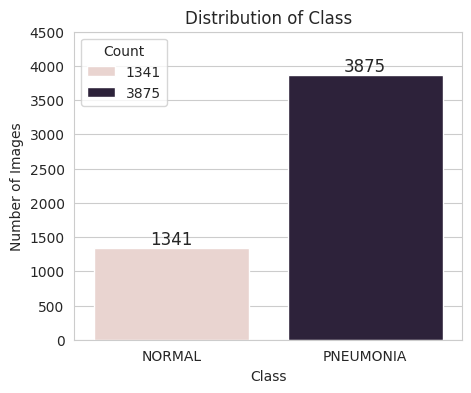

In [10]:
plt.figure(figsize=(5, 4))
sns.barplot(
    data=df,
    x='Class',
    y='Count',
    hue='Count'
)
plt.title("Distribution of Class")
plt.ylabel("Number of Images")
plt.ylim(0, 4500)
for i, v in enumerate(df['Count']):
    plt.text(i, v+50, str(v), ha='center', fontsize=12)
plt.show()

**Class Imbalance Issue**  
The dataset is imbalanced — there are significantly more **PNEUMONIA** images than **NORMAL** ones. Without correction, the model learns to predict PNEUMONIA almost always and reaches ~74% accuracy by cheating (ignoring the minority class).  

To fix this, we use **class weights** in the loss function, giving **higher importance to the NORMAL class**. This prevents bias toward the majority class and encourages the model to learn proper distinguishing features.

#### Previewing images of two class

In [11]:
train_data[0][1], train_data[-1][1]

(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].


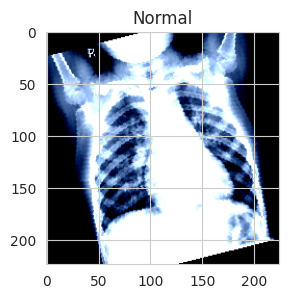

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1585187].


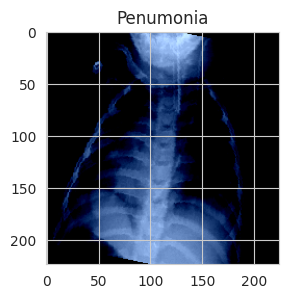

In [12]:
plt.figure(figsize=(3, 5))
plt.imshow(train_data[0][0].permute(1, 2, 0).numpy())
plt.title("Normal")
plt.show()

plt.figure(figsize=(3, 5))
plt.imshow(train_data[-1][0].permute(1, 2, 0).numpy())
plt.title("Penumonia")
plt.show()

In [13]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device", device)

Device cuda


## Class Weight for Imbalance Data
Since the **NORMAL** class (label 0) is the minority class, we assign **higher weight** to it in the loss function.  
This means misclassifying a NORMAL sample will incur a larger penalty, forcing the model to pay more attention to correctly identifying NORMAL cases and preventing it from trivially predicting everything as PNEUMONIA.

In [14]:
class_counts = Counter(train_data.targets)
num_samples = len(train_data.targets)

class_weights = [
    num_samples / (class_counts[i] * len(class_counts)) 
    for i in class_counts 
]

class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Select resnet18 Model and Trainig Model

In [15]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Early Stopping Setup

patience = 3 
best_val_loss = float('inf')
counter = 0
epochs = 20

### Training Loop + EarlyStopping

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch: {epoch} | Train_Loss: {train_loss} | Val_Loss: {val_loss} ")

    # ------Early Soping---------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0 
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved")
        
    else:
        counter += 1
        print(f"No improvement {counter} / {patience}")

    if counter >= patience:
        print("Early Stoping Treggered")
        break

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Epoch: 0 | Train_Loss: 0.1379232471123155 | Val_Loss: 0.1419222354888916 
✅ Best model saved
Epoch: 1 | Train_Loss: 0.07593576097289569 | Val_Loss: 0.675626277923584 
No improvement 1 / 3
Epoch: 2 | Train_Loss: 0.06283481191255244 | Val_Loss: 0.28577256202697754 
No improvement 2 / 3
Epoch: 3 | Train_Loss: 0.0488998291305512 | Val_Loss: 0.6543648838996887 
No improvement 3 / 3
Early Stoping Treggered


## Evaluation Model 

In [16]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        _, predicted = torch.max(output, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

In [17]:
print("\n===== Test Metrics =====")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


===== Test Metrics =====
Accuracy : 88.14%
Precision: 0.8420
Recall   : 0.9974
F1 Score : 0.9131


## Analysis After Model Training

<Axes: >

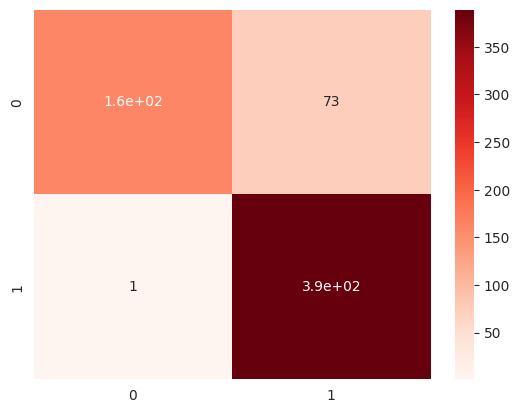

In [18]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap='Reds', annot=True)

### Confusion Matrix Analysis & Key Observations

From the confusion matrix, we observe that the number of **False Positives (FP)** is noticeably higher than the number of **False Negatives (FN)**.

This means the model tends to **over-predict pneumonia** more often than it misses actual pneumonia cases.

**Possible reasons for higher FP than FN** include:
- The dataset is imbalanced with significantly more PNEUMONIA samples → the model becomes biased toward predicting the majority class.
- The visual features of some NORMAL images (e.g. mild artifacts, poor image quality, or borderline cases) resemble early/mild pneumonia patterns, leading the model to misclassify them as positive.

Despite this imbalance in error types, the **overall number of correct predictions (True Positives + True Negatives)** is substantially higher than the errors (FP + FN). This indicates that the model still achieves reasonably good overall performance and successfully identifies the majority of both classes correctly.

## Grad_CAM
To investigate the reasons behind the higher number of False Positives and understand **what the model is actually looking at**, we apply **Grad-CAM**.

Grad-CAM produces heatmaps showing the image regions that most strongly influenced the model's prediction. This allows us to check:

- whether the model focuses on meaningful pathological areas for PNEUMONIA predictions,
- or is distracted by irrelevant features in NORMAL images (leading to false positives).

The Grad-CAM visualizations are presented in the next section.

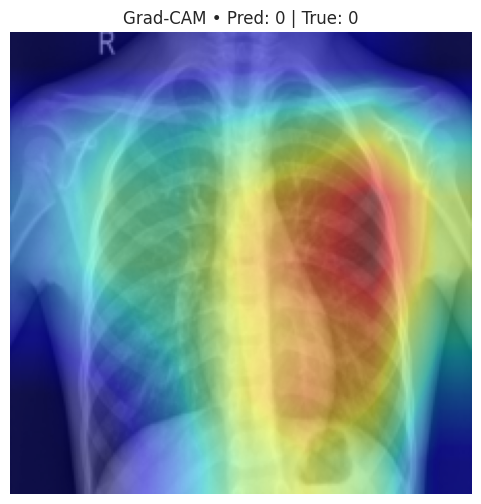

In [19]:
target_layer = model.layer4[-1] 

activations = []
gradients   = []

def forward_hook(module, input, output):
    activations.append(output.detach())         

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0].detach())

handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_full_backward_hook(backward_hook)   

image, label = test_data[0]                    
input_tensor = image.unsqueeze(0).to(device)   

model.eval()
model.zero_grad()

output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

output[0, pred_class].backward()

handle_f.remove()
handle_b.remove()


if not gradients or not activations:
    print("Error: hooks did not capture gradient/activation")
else:
    grad = gradients[0].cpu().numpy()[0]       
    act = activations[0].cpu().numpy()[0]      

    weights = np.mean(grad, axis=(1, 2))     

    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)

    if cam.max() > 0:
        cam = cam / cam.max()

    cam = cv2.resize(cam, (224, 224))         

    img_display = image.permute(1, 2, 0).cpu().numpy()

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_display = img_display * std + mean
    img_display = np.clip(img_display, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.imshow(cam, cmap='jet', alpha=0.45)     
    plt.title(f"Grad-CAM • Pred: {pred_class} | True: {label}")
    plt.axis("off")
    plt.show()

### Grad-CAM Visualization – Correct Prediction (NORMAL)

The Grad-CAM heatmap above was generated for a **correctly classified NORMAL** sample (Predicted: 0 – NORMAL | True: 0 – NORMAL).

**Key observations from the heatmap:**
- The strongest activation (bright red/yellow regions) is concentrated primarily in the **central lung fields** and along the **mediastinal structures** (heart and trachea area).
- However, in a true NORMAL chest X-ray, we expect the model to **not** focus intensely on any specific pathological pattern. Instead, the heatmap should ideally show relatively diffuse or low-intensity activation across the lungs without sharp hotspots.
- Here, the model appears to place significant attention on the **upper central chest** (including areas around the clavicles and upper lung zones), which may indicate it is using **anatomical landmarks** (such as ribs, heart shadow, or vascular structures) rather than actual pneumonia-related opacities to make its decision.
- Importantly, no strong red/orange hotspots are seen in the lower lung zones or peripheral areas — regions where consolidation or infiltrates typical of pneumonia would appear. This supports why the model correctly classified this image as NORMAL.

**Interpretation & Insight:**
This visualization suggests the model has learned to recognize the **absence** of pneumonia by focusing on normal anatomical structures rather than being confused by artifacts or subtle variations. However, the relatively high activation in non-pathological areas (e.g. mediastinum) highlights a potential area for improvement: the model could benefit from better attention to lung parenchyma specifically.

In contrast, we will later examine Grad-CAM for misclassified (False Positive) cases to see if the model is incorrectly activating on normal structures that mimic mild pneumonia patterns.

This kind of interpretability helps build trust in the model and guides future refinements (e.g. better data augmentation, attention mechanisms, or targeted loss terms).